# Time series modeling

The EDA notebook has ACF, PACF, resampling of tweet data.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# import resampled data by minute.
rdf_path = '../merged_data/resampled_tudf_minute_basic.csv'
rdf = pd.read_csv(rdf_path, parse_dates=True, index_col='created_at')

In [3]:
#resampled data frame
rdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8774 entries, 2022-04-29 19:46:00+00:00 to 2022-05-05 21:59:00+00:00
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tweet_rate_60                      8441 non-null   float64
 1   tweet_rate_600                     8417 non-null   float64
 2   time_since_last_tweet_rolling_60   8441 non-null   float64
 3   time_since_last_tweet_rolling_600  8417 non-null   float64
dtypes: float64(4)
memory usage: 342.7 KB


In [4]:
rdf.index

DatetimeIndex(['2022-04-29 19:46:00+00:00', '2022-04-29 19:47:00+00:00',
               '2022-04-29 19:48:00+00:00', '2022-04-29 19:49:00+00:00',
               '2022-04-29 19:50:00+00:00', '2022-04-29 19:51:00+00:00',
               '2022-04-29 19:52:00+00:00', '2022-04-29 19:53:00+00:00',
               '2022-04-29 19:54:00+00:00', '2022-04-29 19:55:00+00:00',
               ...
               '2022-05-05 21:50:00+00:00', '2022-05-05 21:51:00+00:00',
               '2022-05-05 21:52:00+00:00', '2022-05-05 21:53:00+00:00',
               '2022-05-05 21:54:00+00:00', '2022-05-05 21:55:00+00:00',
               '2022-05-05 21:56:00+00:00', '2022-05-05 21:57:00+00:00',
               '2022-05-05 21:58:00+00:00', '2022-05-05 21:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='created_at', length=8774, freq=None)

ARIMA is not a good model for this data, but is a first step. As of the evening of May 9 (working), there is a gap in the data in late may 3 (data), which can be filled with remaining tweets. The model should fit on data before this.

Using diffs $d = 0$ as a first step for slowly trending data.

Using lags $p = 60*24$ to regress --- this is a day of lag with minute-sampled data. mins/hour X hours/day. 

Using errors $q = ??$ to regress. I have the least intuition on this value, but since it is based on short-term changes, I will assume is on the minute - tens of minutes scale of shocks.

<AxesSubplot:xlabel='created_at'>

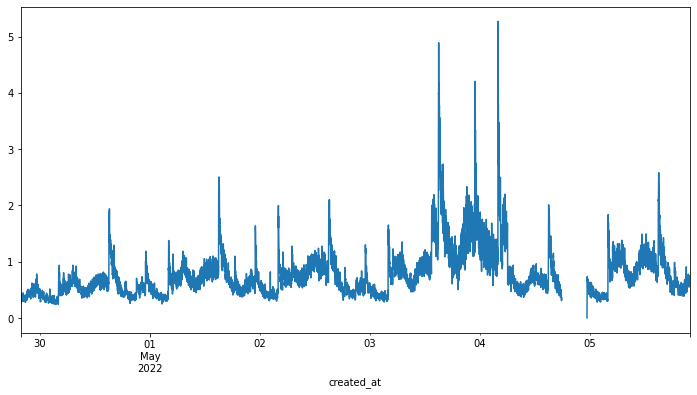

In [6]:
rdf['tweet_rate_60'].plot(figsize = (12,6))

<AxesSubplot:xlabel='created_at'>

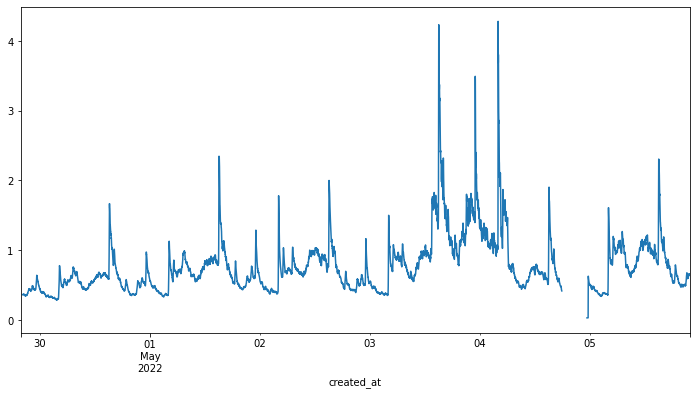

In [7]:
rdf['tweet_rate_600'].plot(figsize = (12,6))

In [8]:
first_date = rdf.index.min()
last_date = rdf.index.max()
first_date, last_date

(Timestamp('2022-04-29 19:46:00+0000', tz='UTC'),
 Timestamp('2022-05-05 21:59:00+0000', tz='UTC'))

In [8]:
##tts
# put tzinfo in later
y_train, y_test = train_test_split(rdf['tweet_rate_600'].loc[:dt.datetime(2022,5,4,0,0)], train_size=0.1, shuffle = False)

C:\Users\David\AppData\Local\Temp/ipykernel_6484/1154449206.py:3: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  y_train, y_test = train_test_split(rdf['tweet_rate_600'].loc[:dt.datetime(2022,5,4,0,0)], train_size=0.1, shuffle = False)


In [9]:
arima = ARIMA( endog = y_train.astype(float).dropna(),
             order = (60*24, 0, 5) # 1 day, no diff, 5 minutes
)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


In [ ]:
%%time
arima_model = arima.fit()